In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from enum import Enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( Enum ):
    _10SEC = 'gym-10sec'
    _10SEC_AVG = 'gym-10sec-avg'
    _30SEC = 'gym-30sec'
    _30SEC_AVG = 'gym-30sec-avg'
    _1MIN = 'gym-1min'
    _1MIN_AVG = 'gym-1min-avg'
    _5MIN = 'gym-5min'
    _5MIN_AVG = 'gym-5min-avg'
    
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'resolutions' ]

df = {}
for k in DF :
    temp = [ None ] * 2
    temp[ 0 ] = pd.read_csv( os.path.join( *path, 'ds-%s-train.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    temp[ 1 ] = pd.read_csv( os.path.join( *path, 'ds-%s-test.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    df[ k ] = temp

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._10SEC: 9,
    DF._10SEC_AVG: 9,
    DF._30SEC: 9,
    DF._30SEC_AVG: 9,
    DF._1MIN: 3,
    DF._1MIN_AVG: 3,
    DF._5MIN: 3,
    DF._5MIN_AVG: 4
}

for k, d in df.items():
    temp = [ 
        d[ 0 ].drop( 'occ', axis = 1 ), # x train
        d[ 1 ].drop( 'occ', axis = 1 ), # x test
        d[ 0 ].occ, # y train
        d[ 1 ].occ ] # y test
    
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ],
        temp[ Y_TRAIN ],
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._10SEC Counter({'M': 430, 'L': 202, 'H': 189})
After balancing: DF._10SEC Counter({'M': 430, 'H': 430, 'L': 430})

Before balancing: DF._10SEC_AVG Counter({'M': 430, 'L': 202, 'H': 189})
After balancing: DF._10SEC_AVG Counter({'M': 430, 'H': 430, 'L': 430})

Before balancing: DF._30SEC Counter({'M': 149, 'L': 72, 'H': 59})
After balancing: DF._30SEC Counter({'H': 150, 'L': 149, 'M': 149})

Before balancing: DF._30SEC_AVG Counter({'M': 149, 'L': 72, 'H': 59})
After balancing: DF._30SEC_AVG Counter({'L': 149, 'M': 149, 'H': 149})

Before balancing: DF._1MIN Counter({'M': 77, 'H': 34, 'L': 33})
After balancing: DF._1MIN Counter({'M': 77, 'H': 77, 'L': 77})

Before balancing: DF._1MIN_AVG Counter({'M': 77, 'H': 34, 'L': 33})
After balancing: DF._1MIN_AVG Counter({'M': 77, 'H': 77, 'L': 77})

Before balancing: DF._5MIN Counter({'M': 21, 'L': 9, 'H': 5})
After balancing: DF._5MIN Counter({'L': 21, 'M': 21, 'H': 21})

Before balancing: DF._5MIN_AVG Counter({'M': 21, 'L': 

## Training

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from ml.classification import *

params_svc = [ { 
      'C': [ 1, 10, 100 ], # regularization parameter
      'kernel': [ 'rbf' ], # removed linear kernels
      'gamma': [ 1, 10 ] # how curved the separation is
  } ]  

grids = {}
labels = [ 'H', 'L', 'M' ]
exclude = []

### Regular

Dataset  DF._10SEC
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9998062015503877
Test Accuracy:  0.9951456310679612
Test ROCauc (OvR): 1.0

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      0.98      0.99        50
           L       1.00      1.00      1.00        45
           M       0.99      1.00      1.00       111

    accuracy                           1.00       206
   macro avg       1.00      0.99      1.00       206
weighted avg       1.00      1.00      1.00       206


Dataset  DF._10SEC_AVG
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 1.0
Test Accuracy:  1.0
Test ROCauc (OvR): 1.0

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      1.00      1.00        50
           L       1.00      1.00      1.00        45
           M       1.00      1.00      1.00       111

    accuracy                  

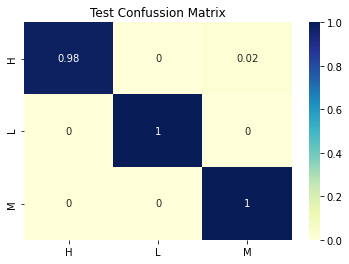

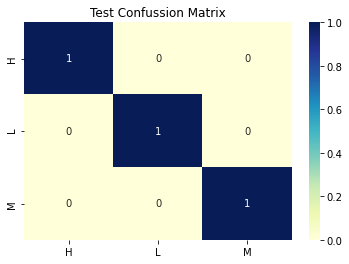

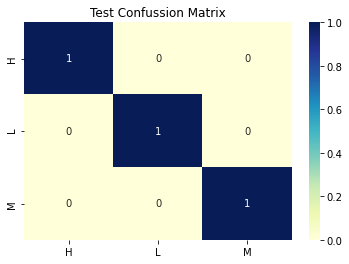

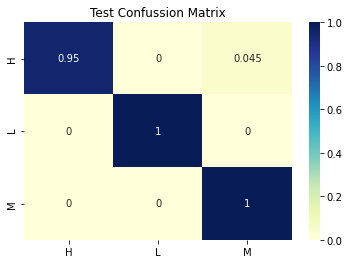

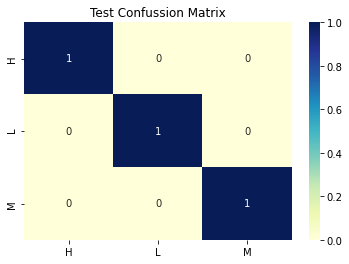

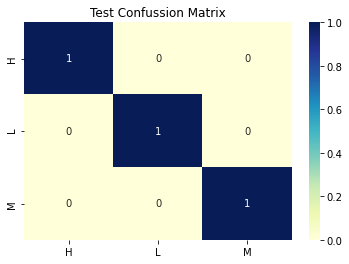

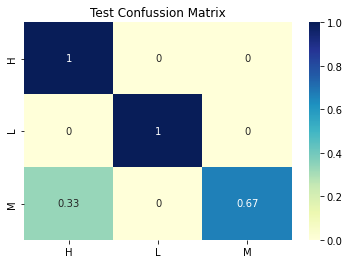

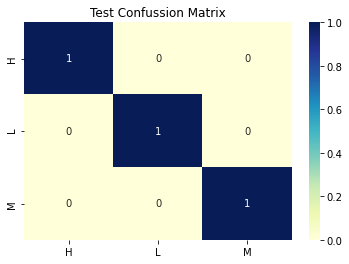

In [5]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k )
        grids[ k ] = train_and_test( 
                SVC( probability = True ), params_svc,  
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

# Evaluation

In [6]:
from ml.evaluation import *

## Learning Curves

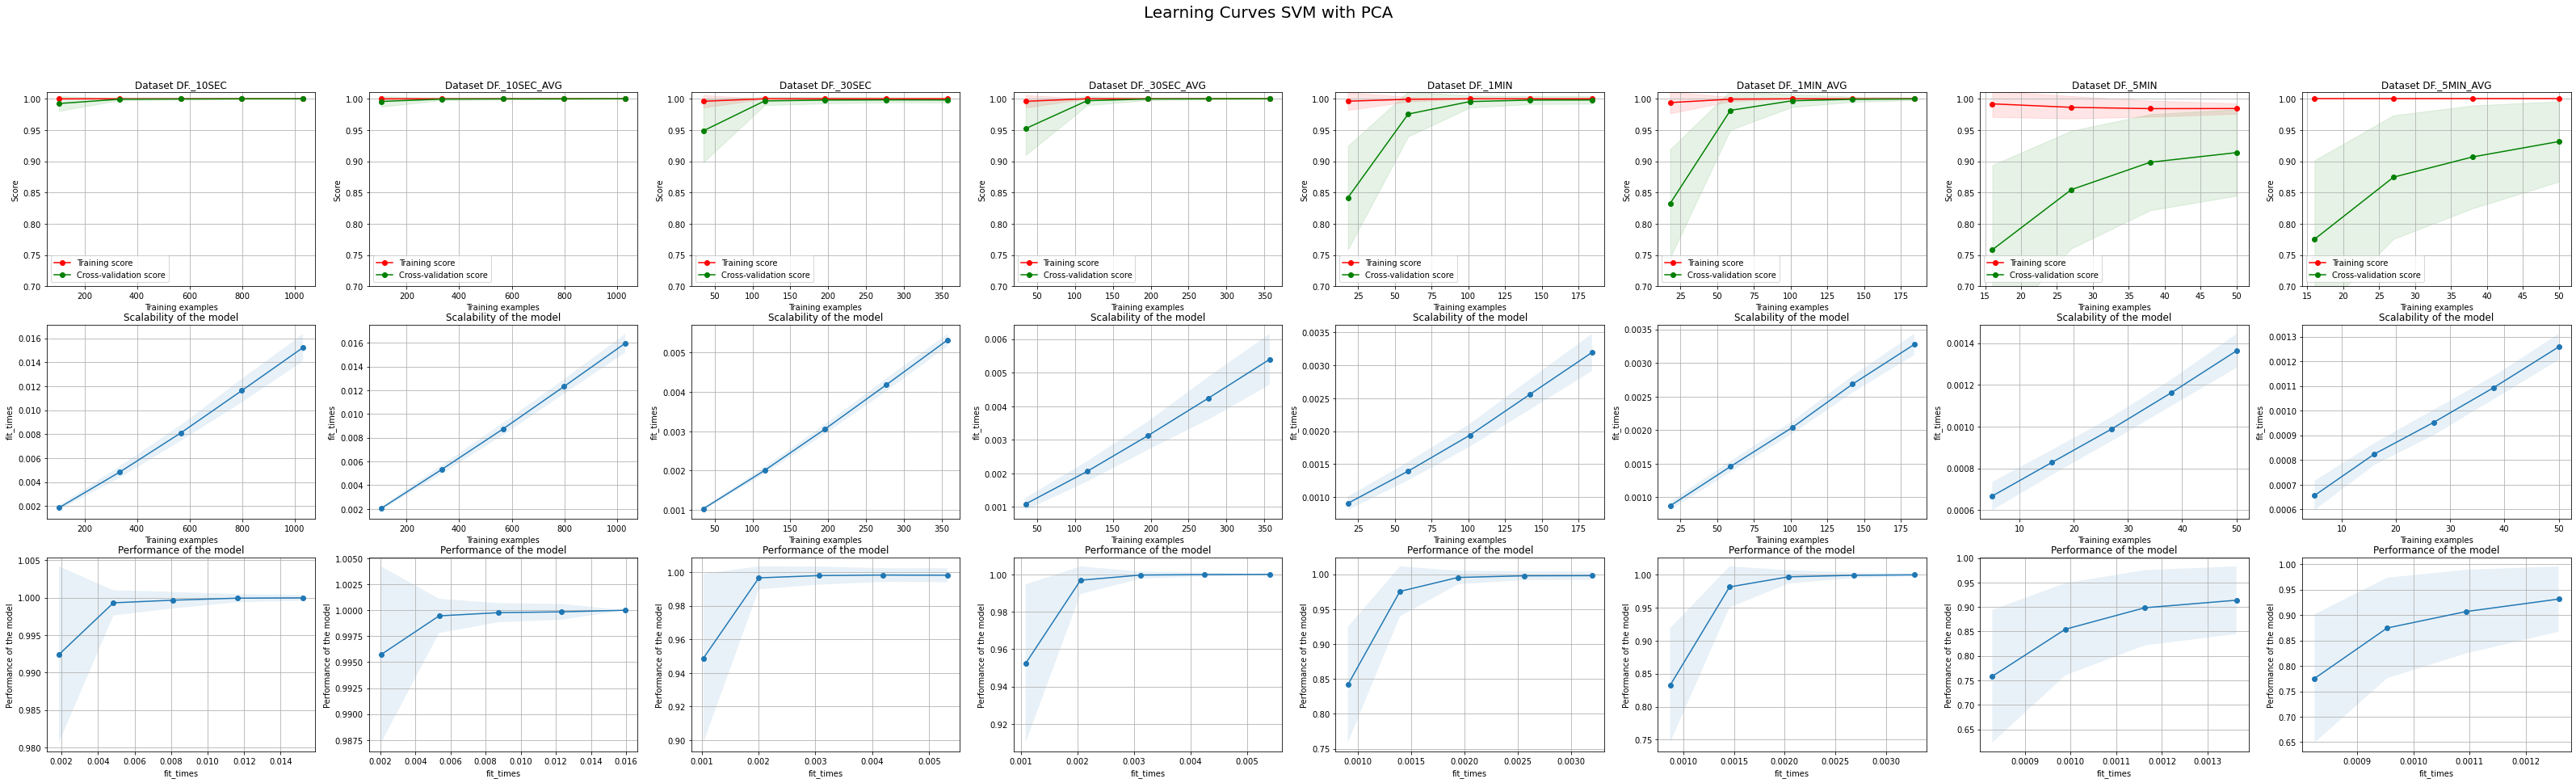

CPU times: user 7.4 s, sys: 329 ms, total: 7.73 s
Wall time: 10.2 s


In [7]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in [] ]
plot_learning_curves( temp, grids, 'SVM' )